# Example: How to run PyRayHF Vertical Forward Operator
This example shows how to call PyRayHF for a given set of input arrays

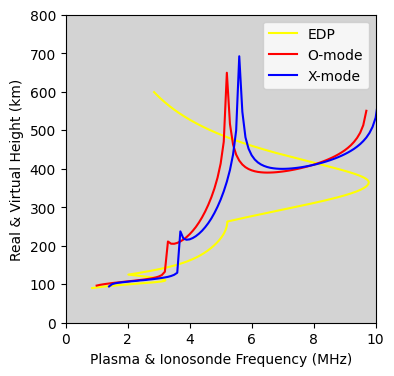

In [1]:
#!/usr/bin/env python
import pickle
import matplotlib.pyplot as plt
import PyRayHF
import numpy as np

# Directory on your local machine where to save the figures
local_dir = '../figures/'

# Load input arrays from the example.
# See Example_Generate_Input_Arrays for how to create input arrays using PyIRI.
file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))

# Instrument Frequency Range
ionosonde_frequency = np.arange(1, 12, 0.1)

# Compute virtual height for the ordinary 'O' propagation mode.
# A low number of vertical grid points is sufficient for O-mode (e.g., 200).
mode = 'O'
n_points = 200
vh_O = PyRayHF.library.vertical_forward_operator(ionosonde_frequency,
                                                 input_arrays['den'],
                                                 input_arrays['bmag'],
                                                 input_arrays['bpsi'],
                                                 input_arrays['alt'],
                                                 mode=mode,
                                                 n_points=n_points)

# Compute virtual height for the extraordinary 'X' propagation mode.
# A high number of vertical grid points is recommended for X-mode (e.g., 20000),
# since the result may be noisy at low resolution.
mode = 'X'
n_points = 200
vh_X = PyRayHF.library.vertical_forward_operator(ionosonde_frequency,
                                                 input_arrays['den'],
                                                 input_arrays['bmag'],
                                                 input_arrays['bpsi'],
                                                 input_arrays['alt'],
                                                 mode=mode,
                                                 n_points=n_points)

# Plot the results.
# The electron density profile (EDP) is converted from plasma density to plasma
# frequency and plotted using real altitude on the y-axis.
# Virtual heights for O-mode and X-mode are plotted with ionosonde frequency on
# the x-axis and virtual height on the y-axis.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_ylim([0, 800])
ax.set_xlim([0, 10])
ax.set_facecolor("lightgray")
ax.set_ylabel('Real & Virtual Height (km)')
ax.set_xlabel('Plasma & Ionosonde Frequency (MHz)')
ax.plot(PyRayHF.library.den2freq(input_arrays['den']) / 1e6, input_arrays['alt'],
        c='yellow', label='EDP', zorder=1)
ax.plot(ionosonde_frequency, vh_O, c='red', label='O-mode', zorder=2)
ax.plot(ionosonde_frequency, vh_X, c='blue', label='X-mode', zorder=2)
plt.legend()
plt.savefig(local_dir + 'Run_Vertical_PyRayHF.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# How Vertical Forward Operator in PyRayHF Works
This Notebook shows how Vertical PyRAY works and helps to visualize the code flow.

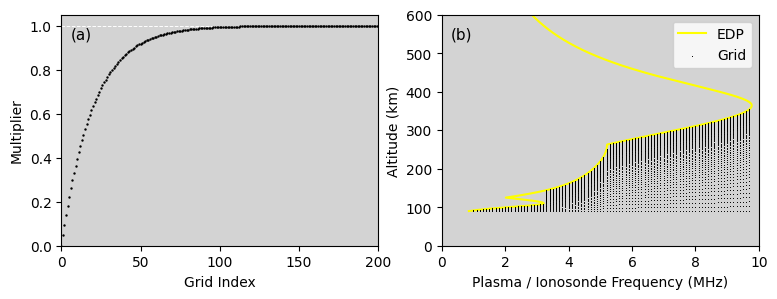

In [2]:
#!/usr/bin/env python
# --------------------------------------------------------
# Distribution Statement A. Approved for public release.
# Distribution is unlimited.
# This work was supported by the Office of Naval Research.
# --------------------------------------------------------
"""Example of work flow in PyRayHF.
"""

import pickle
import numpy as np
import matplotlib.pyplot as plt
import PyRayHF

# Load input arrays from the example.
# See Example_Generate_Input_Arrays for how to create input arrays using PyIRI.
file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))

# Compute virtual height for the ordinary 'O' propagation mode.
# A low number of vertical grid points is sufficient for O-mode (e.g., 200).
mode = 'O'
n_points = 200

# Limit the ionosonde frequency array up tp the ionospheric critical
# frequency foF2 and convert form MHz to Hz.
foF2 = np.max(PyRayHF.library.den2freq(input_arrays['den']))

# Index where ionosonde frequency is less then foF2 value
ind = np.where((input_arrays['freq'] * 1e6) < foF2)

# Select ionosonde frequency with this criteria
freq_lim = input_arrays['freq'][ind] * 1e6

# Make empty array to collect virtual height of the same size as input
# frequency array
vh = np.zeros((input_arrays['freq'].size)) + np.nan

# Interpolate input arrays into a new stretched grid based on the
# reflective height for each ionosonde frequency
# Frequency needs to be converted to MHz from Hz
regridded = PyRayHF.library.regrid_to_nonuniform_grid(freq_lim,
                                                      input_arrays['den'],
                                                      input_arrays['bmag'],
                                                      input_arrays['bpsi'],
                                                      input_arrays['alt'],
                                                      mode=mode,
                                                      n_points=n_points)

# Plot visualization of the new stretched grid
# The electron density profile (EDP) is converted from plasma density to plasma
# frequency.
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(9, 3)
ax_plot = ax[0]
ax_plot.axhline(y=1, linestyle='--', color='white', linewidth=0.7)
ax_plot.set_xlim([0, 200])
ax_plot.set_ylim([0, 1.05])
ax_plot.text(0.03, 0.95, '(a)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Multiplier')
ax_plot.set_xlabel('Grid Index')
ax_plot.scatter(np.arange(0, n_points), PyRayHF.library.smooth_nonuniform_grid(0, 1, n_points, 10), c='black', linewidth=0, s=3, zorder=2)

ax_plot = ax[1]
ax_plot.text(0.03, 0.95, '(b)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')
ax_plot.set_ylim([0, 600])
ax_plot.set_xlim([0, 10])
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Altitude (km)')
ax_plot.set_xlabel('Plasma / Ionosonde Frequency (MHz)')
ax_plot.plot(PyRayHF.library.den2freq(input_arrays['den']) / 1e6, input_arrays['alt'],
        c='yellow', label='EDP', zorder=1)
ax_plot.scatter(regridded['freq'] / 1e6, regridded['alt'], c='black', linewidth=0, s=0.5, label='Grid')
plt.legend()
plt.savefig(local_dir + 'Stretched_Grid.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

Plot visualization of the input arrays interpolated to the new grid 

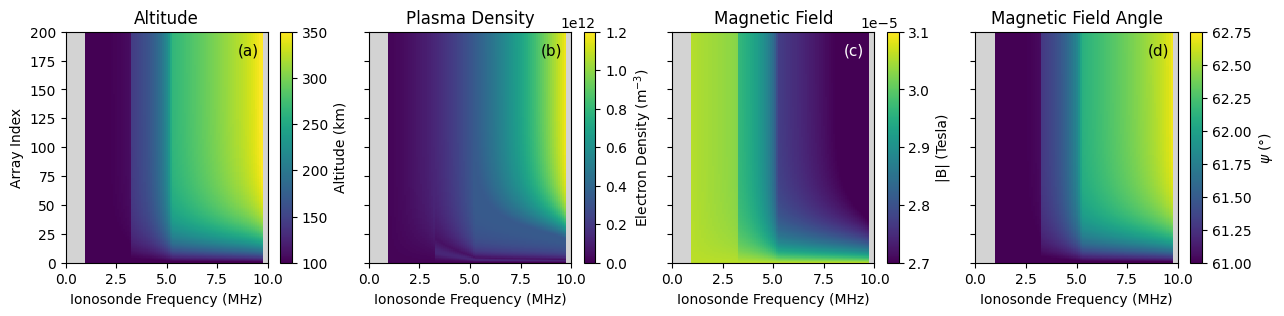

In [3]:
fig, ax = plt.subplots(1, 4, sharey=True, sharex=True)
fig.set_size_inches(15, 3)

ax_plot = ax[0]
ax_plot.set_ylim([0, 200])
ax_plot.set_title('Altitude')
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Array Index')
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], regridded['alt'])
cbar = fig.colorbar(mesh, ax=ax_plot)
ax_plot.text(0.853, 0.95, '(a)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')
mesh.set_clim(100, 350)
cbar.set_label('Altitude (km)')

ax_plot = ax[1]
ax_plot.set_ylim([0, 200])
ax_plot.set_title('Plasma Density')
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], regridded['den'])
cbar = fig.colorbar(mesh, ax=ax_plot)
mesh.set_clim(0, 1.2e12)
ax_plot.text(0.85, 0.95, '(b)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')
cbar.set_label('Electron Density (m$^{-3}$)')

ax_plot = ax[2]
ax_plot.set_ylim([0, 200])
ax_plot.set_title('Magnetic Field')
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], regridded['bmag'])
cbar = fig.colorbar(mesh, ax=ax_plot)
mesh.set_clim(2.7e-5, 3.1e-5)
ax_plot.text(0.85, 0.95, '(c)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='white')
cbar.set_label('|B| (Tesla)')

ax_plot = ax[3]
ax_plot.set_ylim([0, 200])
ax_plot.set_xlim([0., 10])
ax_plot.set_title('Magnetic Field Angle')
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], regridded['bpsi'])
mesh.set_clim(61, 62.75)
cbar = fig.colorbar(mesh, ax=ax_plot)
ax_plot.text(0.85, 0.95, '(d)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')
cbar.set_label('$ψ$ (°)')

plt.savefig(local_dir + 'Regridded_Input_Matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

Plot intermediate calculations for: the the ratio of the square of the plasma frequency f_N to the square of the ionosonde frequency f (X), the ratio of electron gyrofrequency and the ionosonde frequency (Y), the phase refractive index (μ), and the group refractive index (μ′)

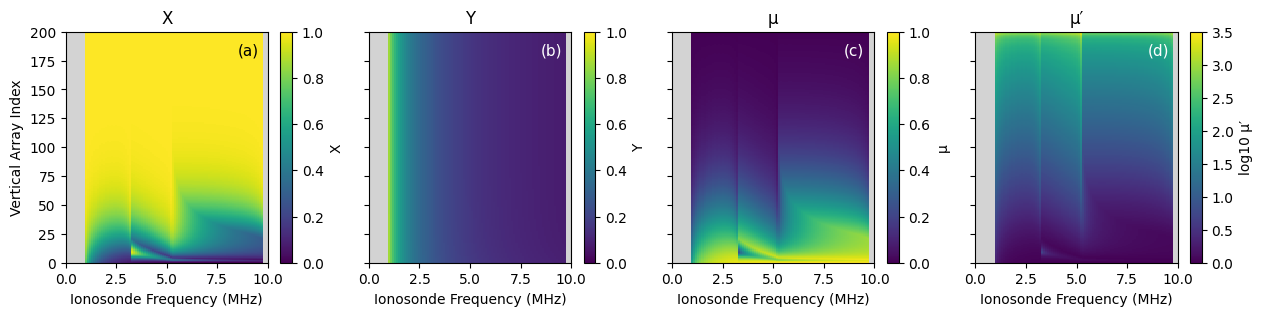

In [4]:
# Find the ratio of the square of the plasma frequency f_N to the square of
# the ionosonde frequency f.
aX = PyRayHF.library.find_X(regridded['den'], regridded['freq'])

# Find the ratio of electron gyrofrequency and the ionosonde frequency
aY = PyRayHF.library.find_Y(regridded['freq'], regridded['bmag'])

# Find the phase refractive index μ and the group refractive index μ′
mu, mup = PyRayHF.library.find_mu_mup(aX, aY, regridded['bpsi'], mode)

# Plot visualization of the X and Y raytracing variables
fig, ax = plt.subplots(1, 4, sharey=True, sharex=True)
fig.set_size_inches(15, 3)
ax_plot = ax[0]
ax_plot.set_ylim([0, 200])
ax_plot.set_xlim([0., 10])
ax_plot.set_title('X')
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Vertical Array Index')
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], aX)
mesh.set_clim(0, 1.)
cbar = fig.colorbar(mesh, ax=ax_plot)
cbar.set_label('X')
ax_plot.text(0.85, 0.95, '(a)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')


ax_plot = ax[1]
ax_plot.set_ylim([0, 200])
ax_plot.set_xlim([0., 10])
ax_plot.set_title('Y')
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], aY)
mesh.set_clim(0, 1.)
cbar = fig.colorbar(mesh, ax=ax_plot)
cbar.set_label('Y')
ax_plot.text(0.85, 0.95, '(b)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='white')


ax_plot = ax[2]
ax_plot.set_ylim([0, 200])
ax_plot.set_xlim([0., 10])
ax_plot.set_title('μ')
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], mu)
mesh.set_clim(0, 1.)
cbar = fig.colorbar(mesh, ax=ax_plot)
cbar.set_label('μ')
ax_plot.text(0.85, 0.95, '(c)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='white')


ax_plot = ax[3]
ax_plot.set_ylim([0, 200])
ax_plot.set_xlim([0., 10])
ax_plot.set_title('μ′')
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], np.log10(mup))
mesh.set_clim(0, 3.5)
cbar = fig.colorbar(mesh, ax=ax_plot)
cbar.set_label('log10 μ′')
plt.savefig(local_dir + 'Intermediate_Calculations.png', dpi=300, bbox_inches='tight', facecolor='white')
ax_plot.text(0.85, 0.95, '(d)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='white')
plt.show()

The virtual height is the integral of μ′, or the multiplication of the μ′ matrix with the matrix that contains distances between the vertical grid points.

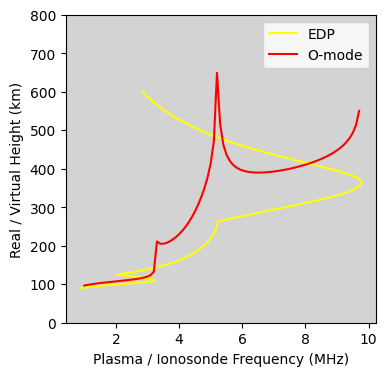

In [5]:
# Find virtual height as vertical integral through μ′
vh[ind] = np.nansum(mup * regridded['dist'], axis=1) + np.min(input_arrays['alt'])

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_ylim([0, 800])
ax.set_facecolor("lightgray")
ax.set_ylabel('Real / Virtual Height (km)')
ax.set_xlabel('Plasma / Ionosonde Frequency (MHz)')
ax.plot(PyRayHF.library.den2freq(input_arrays['den']) / 1e6, input_arrays['alt'],
        c='yellow', label='EDP', zorder=1)
ax.plot(input_arrays['freq'], vh, c='red', label='O-mode', zorder=2)
plt.legend()
plt.savefig(local_dir + 'Virtual_Height.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()